In [ ]:
import os 
from glob import glob

import numpy as np

import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
import nc_time_axis
import cftime

from utils.global_paths import project_data_path, project_code_path, loca_path

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

cm_data = np.loadtxt("./utils/lapaz.txt")[::-1]
lapaz_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

cm_data = np.loadtxt("./utils/lajolla.txt")[::-1]
lajolla_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

# Daily timeseries

In [3]:
##############
### Models ###
##############

models = os.listdir(f"{loca_path}/")
models.remove('training_data')
models.remove('scripts')

loca_all = {}

# Loop through models
for model in models:
    loca_all[model] = {}
    # Loop through members
    members = os.listdir(f"{loca_path}/{model}/0p0625deg/")
    for member in members:
        # Append SSPs
        ssps = os.listdir(f"{loca_path}/{model}/0p0625deg/{member}/")
        loca_all[model][member] = ssps

# Matches website (https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/) as of Jan 2023
print(f"# models: {len(models)}")
print(f"# model/expts: {np.sum([len(np.unique([item for row in [loca_all[model][member] for member in loca_all[model].keys()] for item in row])) for model in models])}")
print(f"# model/expts/ens: {np.sum([len(loca_all[model][ssp]) for model in models for ssp in loca_all[model]])}")
print(f"# model/expts/ens (not including historical): {np.sum([len([ssp for ssp in loca_all[model][member] if ssp != 'historical']) for model in models for member in loca_all[model]])}")

# models: 27
# model/expts: 99
# model/expts/ens: 329
# model/expts/ens (not including historical): 221


In [6]:
lats = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy")
lons = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy")

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    # return array[idx]

In [8]:
find_nearest(lats, lat)

123

In [9]:
sim_id = file_names[0].replace(".npz", "")
npz = np.load(f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/{sim_id}.npz")

In [ ]:
nt = npz['out'].shape[1]
    
out_full = np.full((len(npz['valid_inds']), nt), np.nan)
out_full[npz['valid_inds']] = npz['out']

In [ ]:
out_full.shape

In [4]:
def get_soilMoist_metrics(subset_name, ensemble_name, file_name, lat, lon, time_slice):
    # Read simulation
    sim_id = file_name.replace(".npz", "")
    npz = np.load(f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/{sim_id}.npz")

    # Construct xarray
    lats = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lat.npy")
    lons = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_lon.npy")
    nt = npz['out'].shape[1]
    
    out_full = np.full((len(npz['valid_inds']), nt), np.nan)
    out_full[npz['valid_inds']] = npz['out']
    
    ds_sim = xr.Dataset(data_vars=dict(soilMoist=(["time", "lat", "lon"], 
                                                  np.transpose(out_full.reshape(len(lons), len(lats), nt), (2,1,0)))),
                        coords=dict(lon=lons, lat=lats,
                                    time=xr.cftime_range(start='2023-01-01', periods=nt, calendar='365_day')))

    # Select grid point and time slice
    return ds_sim.sel(lat=lat, lon=lon, method='nearest').sel(time=time_slice)

In [5]:
subset_name = "eCONUS"
ensemble_name = "LOCA2"

lat, lon = 40.61752192312278, -88.68366477345201
time_slice = slice("2020", "2030")

# Parallelize with dask delayed
delayed = []

# Get simulations
file_names = os.listdir(f"{project_data_path}/projections/{subset_name}/out/{ensemble_name}/")

# Run it
for file_name in file_names:
    # Only take first member
    model, member = file_name.split('_')[:2]
    if member == list(loca_all[model].keys())[0]:
        delayed.append(dask.delayed(get_soilMoist_metrics)(subset_name=subset_name,
                                                           ensemble_name=ensemble_name,
                                                           file_name=file_name,
                                                            lat=lat, lon=lon,
                                                            time_slice=time_slice))
    
# Compute
print(len(delayed))
# _ = dask.compute(*delayed)

NameError: name 'get_soilMoist_metrics' is not defined

In [6]:
2340*30/60/60/30

0.65

In [ ]:
%%time
y = get_soilMoist_metrics(subset_name, ensemble_name, file_names[0], lat, lon, time_slice)

In [7]:
%%time
x = get_soilMoist_metrics(subset_name, ensemble_name, file_names[0], lat, lon, time_slice)

CPU times: user 6.77 s, sys: 5.78 s, total: 12.6 s
Wall time: 18 s


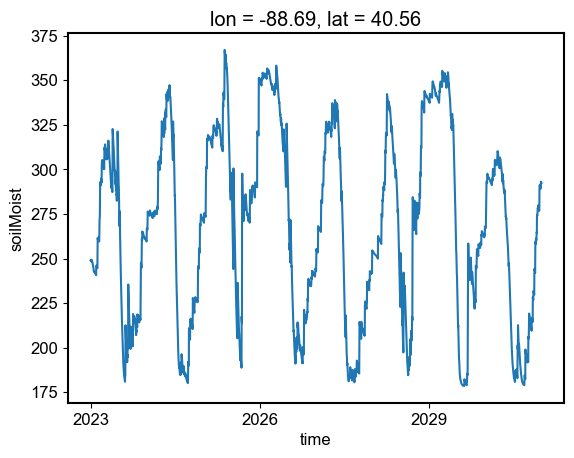

In [9]:
x['soilMoist'].plot()

# Soil moisture product intercomparison 

In [32]:
# Read all
obs_names = ['SMAP', 'VIC', 'NOAH', 'MOSAIC']

subset_name = 'eCONUS'

ds_obs_all = []

for obs_name in obs_names:
    ds = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    ds = ds.assign_coords(obs_name = obs_name)
    ds_obs_all.append(ds)

ds_obs_all = xr.concat(ds_obs_all, dim='obs_name').drop_vars('depth')['soilMoist']

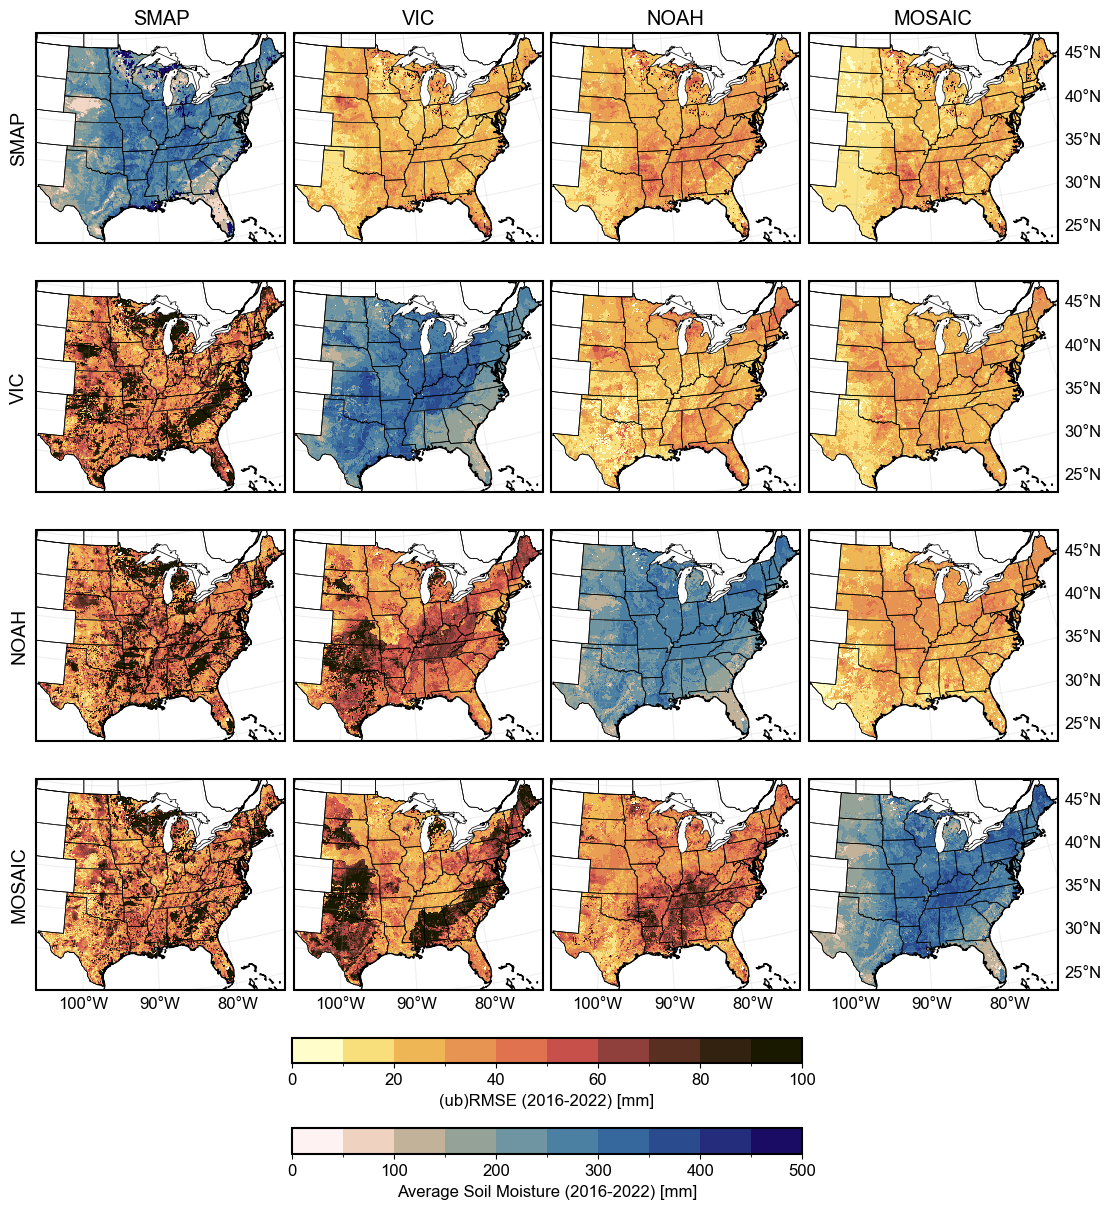

In [50]:
# Pairwise comparison
cmap_mean = lapaz_cmap
vmax_mean = 500.

cmap_diff = lajolla_cmap
vmax_diff = 100.

fig, axs = plt.subplots(4,4, figsize=(11,12), sharex=True, sharey=True, layout="constrained",
                    subplot_kw=dict(projection=ccrs.LambertConformal()))

# Loop through combinations
for ido1, obs_name1 in enumerate(obs_names):
    for ido2, obs_name2 in enumerate(obs_names):
        ax = axs[ido1, ido2]
        # Diagonal: mean
        if ido1 == ido2:
            pmean = ds_obs_all.isel(obs_name = ido1).mean(dim='time').plot(ax=ax, vmin=0, vmax=vmax_mean, levels=11, cmap=cmap_mean, add_colorbar=False, transform=ccrs.PlateCarree())
            ax.set_title('')
        # RMSE
        elif ido1 > ido2:
            ds_rmse = np.sqrt(((ds_obs_all.isel(obs_name = ido1) - ds_obs_all.isel(obs_name = ido2))**2).mean(dim='time'))
            ds_rmse.plot(ax=ax, vmin=0, vmax=vmax_diff, levels=11, cmap=cmap_diff, add_colorbar=False, transform=ccrs.PlateCarree())
        # ubRMSE
        elif ido2 > ido1:
            ds1_cenered = ds_obs_all.isel(obs_name = ido1) - ds_obs_all.isel(obs_name = ido1).mean(dim='time')
            ds2_cenered = ds_obs_all.isel(obs_name = ido2) - ds_obs_all.isel(obs_name = ido2).mean(dim='time')
            ds_rmse = np.sqrt(((ds1_cenered - ds2_cenered)**2).mean(dim='time'))
            pdiff = ds_rmse.plot(ax=ax, vmin=0, vmax=vmax_diff, levels=11, cmap=cmap_diff, add_colorbar=False, transform=ccrs.PlateCarree())
        
        # Tidy
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.2)
        gl.top_labels = False
        gl.left_labels = False
        gl.bottom_labels = False
        gl.right_labels = False
        
        if ido2 == 0:
            ax.text(-0.07, 0.5, obs_name1, horizontalalignment='center', fontsize=14,
                    rotation=90, verticalalignment='center', transform=ax.transAxes)
        if ido1 == 0:
            ax.set_title(obs_name2)
        if ido2 == 3:
            gl.right_labels = True
        if ido1 == 3:
            gl.bottom_labels = True
        

# Tidy
for ax in axs.flatten():
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.set_extent([-106, -73.5, 25, 49], ccrs.Geodetic())

# Colorbars
fig.colorbar(pmean, orientation="horizontal",
             label="Average Soil Moisture (2016-2022) [mm]",
             ax=axs, pad=0.02, shrink=0.5)

fig.colorbar(pdiff, orientation="horizontal",
             label="(ub)RMSE (2016-2022) [mm]",
             ax=axs, pad=0.02, shrink=0.5)
    
plt.savefig('../figs/pairwise_product_comparison.png', dpi=600)